# Allan variance

Allan variance (or its square-root, Allan deviation) is a standard method for
analyzing random noise sources in inertial sensors.  See [Standard
[05]][standards] and [Reference [20]][references] for details.  This example
illustrates a simulated Allan deviation analysis.

## Create and visualize the input

Allan deviation analysis requires an extended stationary input signal.  The
device under test must be isolated from vibration and external effects.
Typically a data pre-processing step is also applied to remove biases, scale
factors, and other deterministic error sources.  What remains is assumed to be
random noise.

First we create a 10-hour stationary input signal.

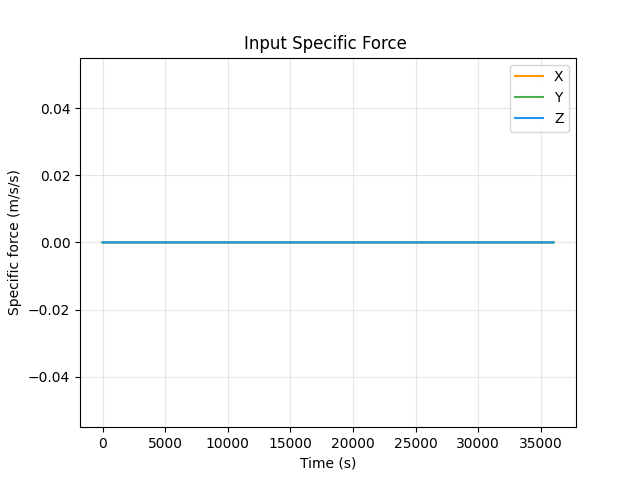

In [1]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# All rights reserved.
# Do not use or redistribute without permission.
# Email: info@inertialsim.com
# -----------------------------------------------------------------------------
%matplotlib widget

import numpy as np

from inertialsim import plot
from inertialsim.geometry import Vector
from inertialsim.time import span

# Create a 10-hour stationary input signal.
sample_rate = 100.0  # Hz
sample_period = 1.0 / sample_rate
num_samples = 10 * 60 * 60 * int(sample_rate) + 1
time = span(0.0, 10 * 3600.0, sample_period)
specific_force = Vector.from_xyz(np.zeros((num_samples, 3, 1)), time)

# Plot the input
sf_plot = plot.TimeSeries(
    title="Input Specific Force ", ylabel="Specific force (m/s/s)"
)
sf_plot.line(specific_force.time, specific_force.as_xyz())
sf_plot.legend(["X", "Y", "Z"])

## Simulate an ideal accelerometer measuring the input

Next we create a single-axis accelerometer as an example.  By default it will
measure the `x-axis` of the input signal.  We set the sensor model to only
include random noise terms and we set the sensor specification to values that do
not necessarily represent any real sensor.

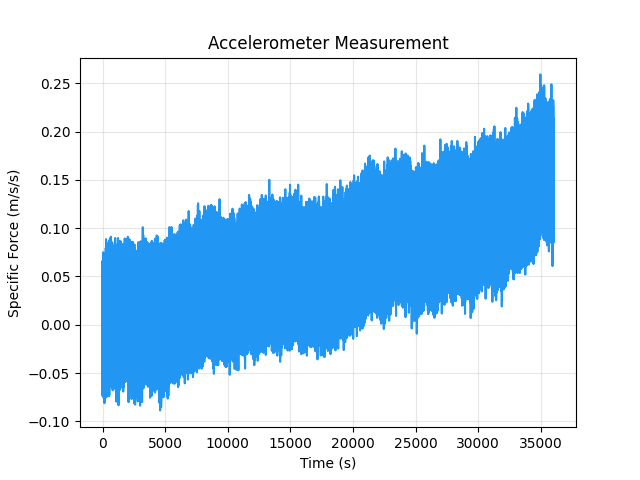

In [2]:
from inertialsim.sensors import Parameter, SensorModel
from inertialsim.sensors.accelerometer import Accelerometer, AccelerometerSpecification

# Create a sensor model that only simulates random noise
model = SensorModel()
model.set_all(value=False)
model.noise.simulate_quantization = True
model.noise.simulate_random_walk = True
model.noise.simulate_bias_instability = True
model.noise.simulate_rate_random_walk = True
model.noise.simulate_rate_ramp = True

# Create a default specification and set some reasonable noise values
specification = AccelerometerSpecification(axes=1)
specification.noise.quantization = Parameter(0.0001, "m/s")
specification.noise.random_walk = Parameter(0.09, "m/s/sqrt(h)")
specification.noise.bias_instability = Parameter(0.3e-3, "g")
specification.noise.rate_random_walk = Parameter(2e-4, "m/s/s/sqrt(s)")
specification.noise.rate_ramp = Parameter(4e-6, "m/s/s/s")

# Create an accelerometer and simulate
accelerometer = Accelerometer(model, specification, rng=10)
result = accelerometer.simulate(specific_force=specific_force)

# Plot the measurement
ts_plot = plot.TimeSeries(
    title="Accelerometer Measurement", ylabel="Specific Force (m/s/s)"
)
ts_plot.line(result.specific_force.time, result.specific_force.data, color="#2196F3")

At the default sample rate (100Hz), 10 hours of data is 3,600,000 data points.
InertialSim is able to simulate the accelerometer measurements in approximately
0.2 seconds.

## Calculate the Allan deviation

Next we input the simulated accelerometer measurement into an Allan deviation
analysis.

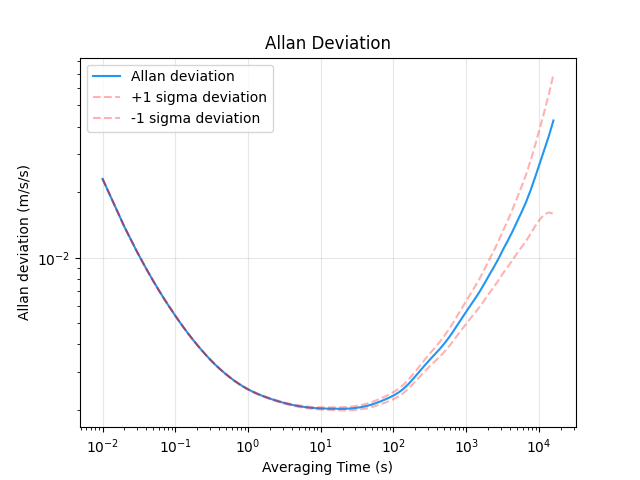

In [3]:
from inertialsim.analysis import AllanDeviation, NoiseModel

# Calculate Allan deviation from the accelerometer measurements
tau, ad, add = AllanDeviation.calculate(result.specific_force)

ad_plot = plot.TimeSeries(title="Allan Deviation", ylabel="Allan deviation (m/s/s)")
ad_plot.axes.set_xlabel("Averaging Time (s)")
ad_plot.loglog(tau, ad, color="#2196F3")
ad_plot.loglog(tau, ad + add, color="red", alpha=0.3, linestyle="--")
ad_plot.loglog(tau, ad - add, color="red", alpha=0.3, linestyle="--")
ad_plot.legend(["Allan deviation", "+1 sigma deviation", "-1 sigma deviation"])

## Analyze the output

Typically, manual curve fitting techniques are used identify the five standard
noise terms that generated the Allan deviation graph above.  See for example
[Standard [05]][standards].  In this example, of course, we know the noise
parameters, so we instead use the simulation to validate our parameter fitting
code.

Manual curve fitting techniques are error prone so InertialSim also supplies an
optimal weighted least squared model fitting option which is demonstrated below.

In [4]:
# Specific which noise parameters we wish to estimate in the least squares
# model.  By default all five standard parameters are estimated.
ad_model = NoiseModel()
model_params = AllanDeviation.fit_model(ad_model, tau, ad, add)

In [5]:
print(
    f"Quantization (m/s).               "
    f"Estimate: {model_params[0, 0]:.8f}, "
    f"True: {specification.noise.quantization.value[0, 0, 0]:.8f}"
)
print(
    f"Random walk (m/s/sqrt(s)).        "
    f"Estimate: {model_params[0, 1]:.8f}, "
    f"True: {specification.noise.random_walk.value[0, 0, 0]:.8f}"
)
print(
    f"Bias instability (m/s/s).         "
    f"Estimate: {model_params[0, 2]:.8f}, "
    f"True: {specification.noise.bias_instability.value[0, 0, 0]:.8f}"
)
print(
    f"Rate random walk (m/s/s/sqrt(s)). "
    f"Estimate: {model_params[0, 3]:.8f}, "
    f"True: {specification.noise.rate_random_walk.value[0, 0, 0]:.8f}"
)
print(
    f"Rate ramp (m/s/s/s).              "
    f"Estimate: {model_params[0, 4]:.8f}, "
    f"True: {specification.noise.rate_ramp.value[0, 0, 0]:.8f}"
)

Quantization (m/s).               Estimate: 0.00009996, True: 0.00010000
Random walk (m/s/sqrt(s)).        Estimate: 0.00150169, True: 0.00150000
Bias instability (m/s/s).         Estimate: 0.00294407, True: 0.00294199
Rate random walk (m/s/s/sqrt(s)). Estimate: 0.00024077, True: 0.00020000
Rate ramp (m/s/s/s).              Estimate: 0.00000321, True: 0.00000400


As can be observed, the estimated parameters match the original parameters we
used in the sensor specification closely.  The error in rate random walk and
rate ramp terms are due to the increasing uncertainty in the Allan deviation
data for long averaging periods on the right hand side of the graph.

## Simulate a realistic accelerometer

Sensor manufacturers typically do not supply all five standard noise terms. Some
may be irrelevant to the specific device technology; some may vary too much
across individual devices; and some are just difficult to measure. Quantization
is typically specified in the data interface section of a specification rather
than as a noise parameter.  Rate random walk and rate ramp terms require
extremely long duration signals to measure accurately (as evidenced by the
1-sigma error bars in the plots above).  This leaves random walk and bias
instability as the terms most commonly published by manufacturers.

He we repeat the above experiment with a 2-hour test on a [Honeywell
HG4930][inertialsim.devices.honeywell_hg4930] IMU from the InertialSim
[devices][inertialsim.devices] library.

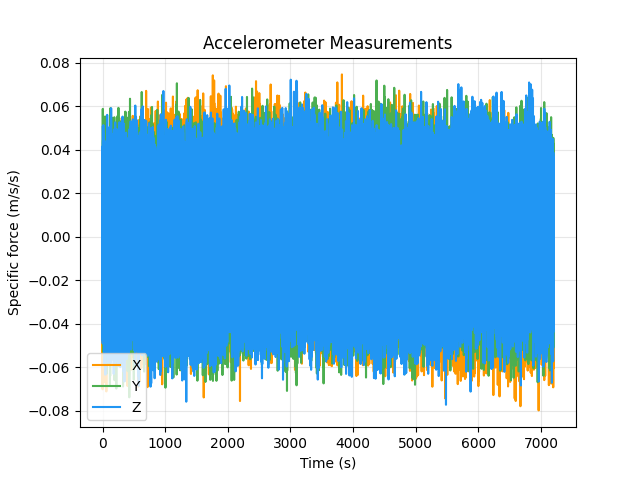

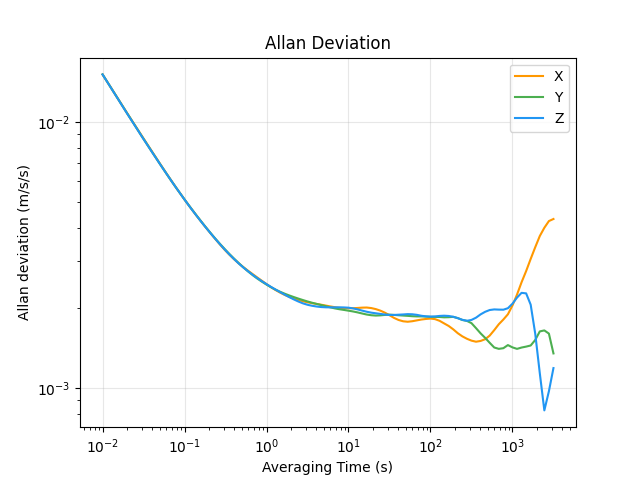

In [6]:
# Import a real IMU specification.  It includes only bias instability and
# velocity random walk terms.  An IMU specification can be used in place of an
# accelerometer specification and the gyro specifications will be ignored.
from inertialsim.devices import honeywell_hg4930

# Trim the input to two hours
specific_force = specific_force[0 : 2 * 60 * 60 * int(sample_rate) + 1]

# Reset the accelerometer and simulate
accelerometer = Accelerometer(model, honeywell_hg4930, rng=0)
result = accelerometer.simulate(specific_force=specific_force)

# Plot the measurement, it is now 3-axis
ts_plot = plot.TimeSeries(
    title="Accelerometer Measurements", ylabel="Specific force (m/s/s)"
)
ts_plot.line(result.specific_force.time, result.specific_force.data)
ts_plot.legend(["X", "Y", "Z"], loc="lower left")

# Perform the Allan deviation analysis again
tau, ad, add = AllanDeviation.calculate(result.specific_force)

ad_plot = plot.TimeSeries(title="Allan Deviation", ylabel="Allan deviation (m/s/s)")
ad_plot.axes.set_xlabel("Averaging Time (s)")
ad_plot.loglog(tau, ad)
ad_plot.legend(["X", "Y", "Z"])

Finally we estimate the noise parameters and observe that they closely match the
specification values.

In [7]:
# This time we only estimate the 2 noise terms that were included in the
# specification.  The terms are estimated independently for each x,y,z axis but we
# print only the x-axis result for clarity.
ad_model = NoiseModel(
    fit_quantization=False, fit_rate_random_walk=False, fit_rate_ramp=False
)
model_params = AllanDeviation.fit_model(ad_model, tau, ad, add)

In [8]:
print(
    f"Random walk (m/s/sqrt(s)).  "
    f"Estimate: {model_params[0, 0]:.8f}, "
    f"True: {specification.noise.random_walk.value[0, 0, 0]:.8f}"
)
print(
    f"Bias instability (m/s/s).   "
    f"Estimate: {model_params[0, 1]:.8f}, "
    f"True: {specification.noise.bias_instability.value[0, 0, 0]:.8f}"
)

Random walk (m/s/sqrt(s)).  Estimate: 0.00150347, True: 0.00150000
Bias instability (m/s/s).   Estimate: 0.00291382, True: 0.00294199


## Determining specifications with Allan deviation data

The most common use for Allan deviation analysis is to determine noise
specifications by measuring real sensors.  The Allan deviation tools in
InertialSim allow users to modify existing device specifications or create new
specifications to match their physical devices.  In this case, the steps above
would be repeated with log data rather than simulated inputs.